**TODO**
- Speed everything up! Maybe the records are taking up too much space? Although I doubt it. The slowness might be unavoidable. 

In [1]:
# Import all the utilities for working with the APR record data. 
from record import *

First, load in all the records from each of the files (I am not sure which one is stimulated and which is unstimulated). The number of records to load can be specified using the `num` keyword argument, which is `None` by default. If no `num` is specified, then all available records are loaded. 

There are 23870145 records in the file, but my laptop can't handle loading them all at once (the process gets killed). Not completely sure the best way to handle this. For this file, I decided to just load in a million. 

In [2]:
records1 = load_records('./data/aprdata1.fq', num=100000)
records2 = load_records('./data/aprdata2.fq', num=100000)

Loading 100000 records from ../data/aprdata1.fq.
34791 records successfully loaded.
Loading 100000 records from ../data/aprdata2.fq.
34791 records successfully loaded.


From this point on, at least for now, I'll just work with the `records1` dataset for the sake of brevity. It will be simple to do the same thing with the other dataset later, if needed!

In [3]:
records = records1

In [4]:
umi2prot = get_umi2prot(records) # Get map from UMI to proteins. 

In [5]:
# Pull out some other useful information from the records. 
all_umis = np.unique([r.umi1 for r in records] + [r.umi2 for r in records])
all_proteins = np.array([umi2prot[u] for u in all_umis])

Gokul mentioned that one useful thing to know was which molecules have diverse interactions, i.e. which molecules interact with molecules from `n` or more other distinct proteins.

**At least 2 distinct proteins**

In [6]:
umis, data = filter_umis(records, unique_proteins=2)

for i in range(len(umis)):
    print(umis[i])
    print(f'PROTEIN: {umi2prot[umis[i]]}')
    unique_interactions = np.unique(all_proteins[np.where(data[i] > 0)])
    unique_interactions = ' '.join(list(unique_interactions))
    print(f'INTERACTS WITH: {unique_interactions}\n')

AAAAACATGACCATGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: Smad4 b-catenin

AAAACTCCGATGTTGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: Smad4 b-catenin

AAACTTCCGATGTTGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: E-cadherin b-catenin

AAATAATCGATGTTGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: E-cadherin b-catenin

AAATCACGATGTTGGCGCCAACATC
PROTEIN: pSmad2
INTERACTS WITH: Smad4 b-catenin

AACAACACGATGTTGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: E-cadherin b-catenin

AACTTTTCTTGTATGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: Smad2/3 b-catenin

AATCAATTGACCATGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: Smad4 b-catenin

AATTATTCGATGTTGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: E-cadherin b-catenin

AATTCCCGATGTTGGCGCCAACATC
PROTEIN: pSmad2
INTERACTS WITH: Smad2/3 b-catenin

AATTTATCGATGTTGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: E-cadherin b-catenin

ACAAATACGATGTTGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: E-cadherin b-catenin

ACACTCACGATGTTGGCGCCAACAT
PROTEIN: pSmad2
INTERACTS WITH: E-cadher

**At least 3 distinct proteins**

It seems as though there aren't any UMIs (in the first 100,000 records) whose interactions span 3 other protein groups. I should probably write a catch to return a more meaningful error message. 

In [8]:
# umis, data = filter_umis(records, unique_proteins=3)

# for i in range(len(umis)):
#     print(umis[i])
#     print(f'PROTEIN: {umi2prot[umis[i]]}')
#     unique_interactions = np.unique(all_proteins[np.where(data[i] > 0)])
#     unique_interactions = ' '.join(list(unique_interactions))
#     print(f'INTERACTS WITH: {unique_interactions}\n')

Another metric to look at is the distribution of numbers of interactions. For each UMI, what is the distribution of the number of links it participates in (i.e. the number of records in which it appears)?

```
def plot_hist(records, 
        target=None, 
        figsize=(40, 40), 
        mode=None, 
        normalize=True, 
        errorbars=True):
    '''
    Creats a histogram using the record data, which is basically just a
    histogram of the edges of the interaction plot. 

    Params
    ------
    target : str, None
        If target is None, then no filtering is done; basically just make a
        histogram of edges in the graph. 
    records : lst
        A list of record objects.
    figsize : (float, float)
        Figure size. 
    mode : str, None
        Indicates the type of the target, either a UMI or a protein. Must be
        specified if a target is specified. 
    normalize : bool
        Whether or not to normalize counts (i.e. make it a real probability
        distribution). 
    '''
```

1


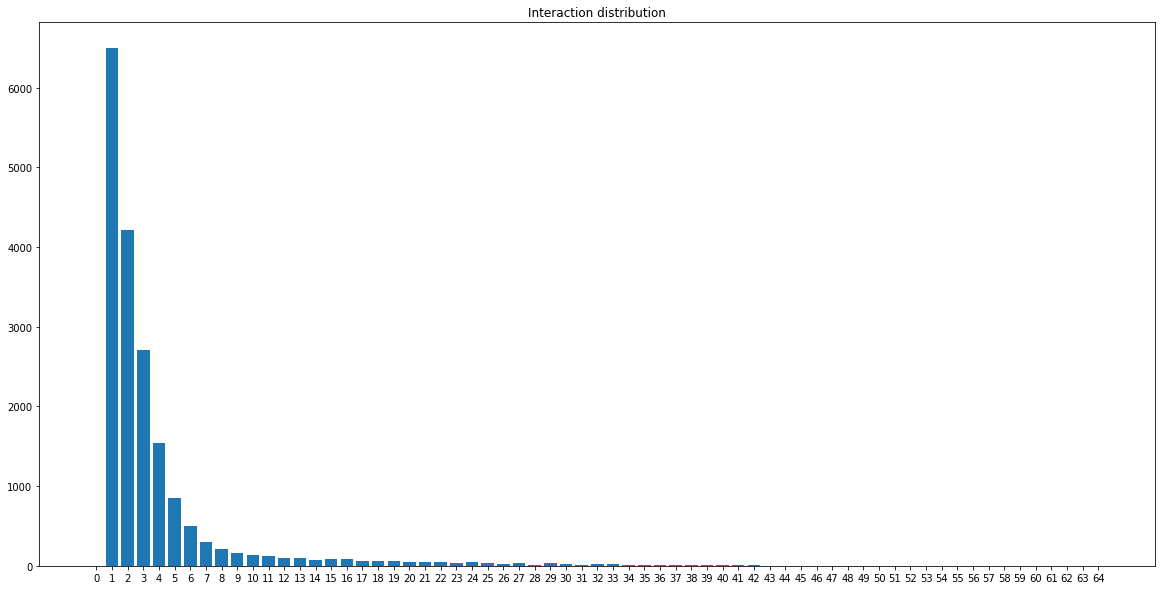

In [14]:
plot_hist(records, figsize=(20, 10), target=None, normalize=False)

Using the `target` and `mode` parameters, you can specify a specific protein or molecule to look at. The plot below gives the interaction participated in by the molecule labeled with `TTCAAACCGATGTTGGCGCCAACAT`, which is one of the UMIs printed as interacting with at least two other proteins. Note that this histogram includes all interactions, not just those with molecules from different proteins. *Should I make it an option to only count interactions with other proteins?*

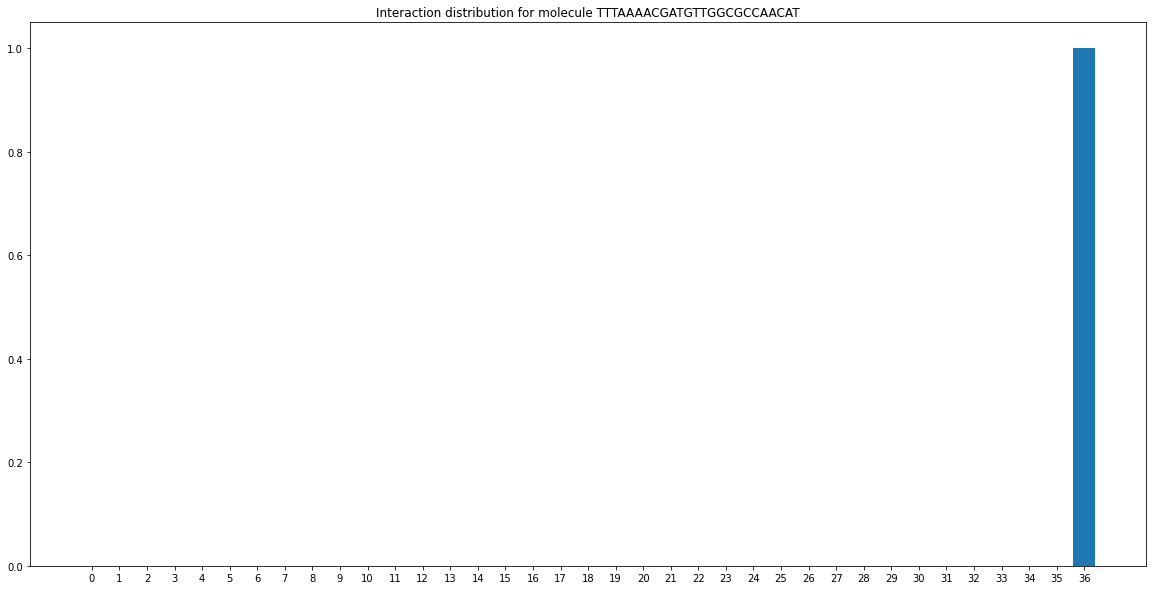

In [6]:
plot_hist(records, figsize=(20, 10), target='TTTAAAACGATGTTGGCGCCAACAT', mode='umi', normalize=False)

Using `mode=prot`, we can look at the interactions between molecules specific to one protein against those specific to other proteins. This is kind of like the histogram equivalent of the interaction networks (plotted below), but does not specify *which* proteins ineract with molecules from the target protein, just the number of interactions.*Would it be useful to divide up the histogram bars into colors according to protein?*

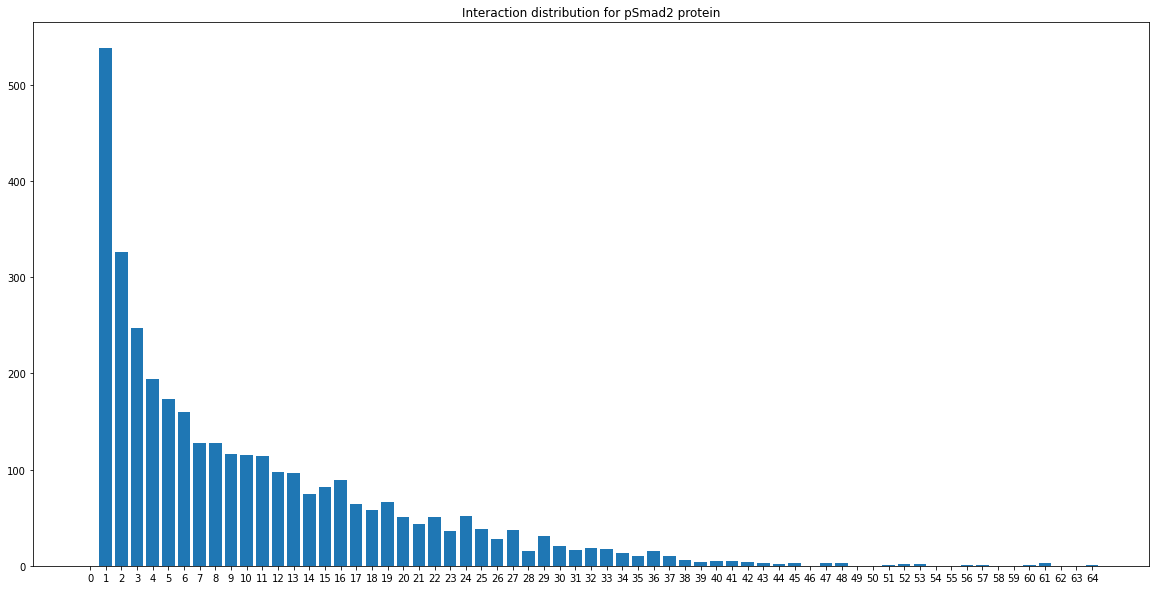

In [7]:
plot_hist(records, figsize=(20, 10), target='pSmad2', mode='prot', normalize=False)

I also visualized the interactions using a; graph. Each node represents one particular molecule, and each edge represents a record in which the UMIs for each molecule are both present. The nodes are grouped and color-coded according to their protein marker. 

```
def plot_interactions(records,
        mode='prot',
        labels=True,
        figsize=(50, 50), 
        spread=5, 
        r=20, 
        c=(0, 0), 
        colors=None, 
        **kwargs):
    '''
    Plots the interactions between proteins or molecules, depending on the
    specified mode. Each node represents one side of an interaction measurement
    (record). 

    Params
    ------
    records : lst
        A list of Record objects. 
    mode : str
        One of 'prot' or 'umi'. Types of interactions to visualize.
    labels : bool
        Whether or not to include group labels.
    figsize : (float, float)
        Figure size. 
    spread : float
        The amount of spacing between points in the same cluster group. 
    '''
```

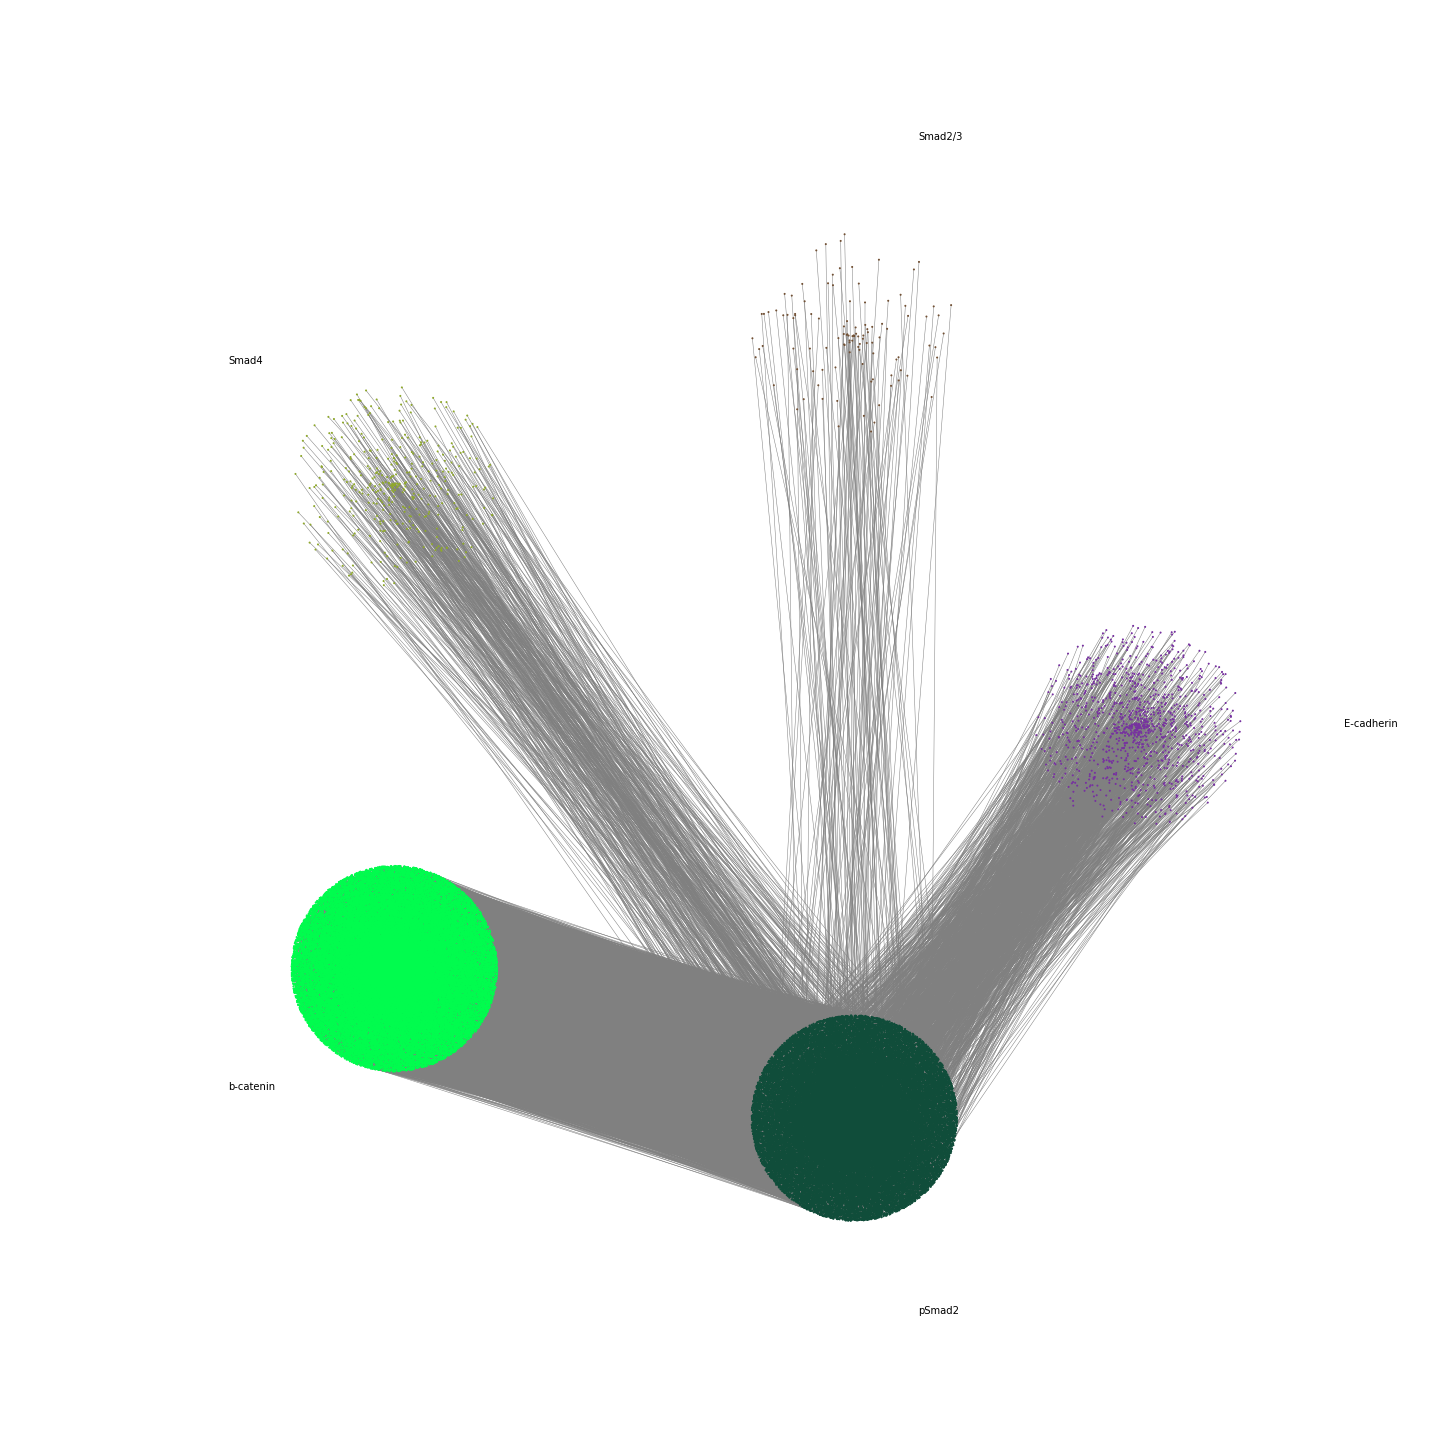

In [12]:
plot_interactions(records, figsize=(20, 20))